# Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import requests

from genderize import Genderize
from datetime import datetime

import matplotlib.patches as patches

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

import mplleaflet

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

import utils

pd.set_option('display.max_columns', 500)

%load_ext autoreload
%autoreload 2

In [2]:
listings_urls = {
    'Paris': 'http://data.insideairbnb.com/france/ile-de-france/paris/2020-02-16/data/listings.csv.gz',
    'LosAngeles': 'http://data.insideairbnb.com/united-states/ca/los-angeles/2020-02-13/data/listings.csv.gz',
    'Sicily': 'http://data.insideairbnb.com/italy/sicilia/sicily/2020-01-30/data/listings.csv.gz'
}

listings_data = utils.load_listings(listings_urls)

Paris data has already downloaded.
Sicily data has already downloaded.
LosAngeles data has already downloaded.


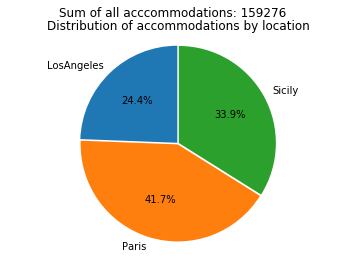

In [3]:
location_distribution = listings_data.groupby('location').apply(lambda x: len(x))
utils.my_plot_pie(location_distribution,
            'Distribution of accommodations by location',
            'Sum of all acccommodations: ' + str(sum(location_distribution))
            )

In [4]:
#check if id index is unique
assert(len(listings_data['id'].unique()) == listings_data['id'].shape[0])

In [5]:
listings_data.set_index('id',append=True,inplace=True)
price_columns = [x for x in listings_data.columns if 'price' in x]
listings_data[price_columns] = listings_data[price_columns].replace('[\$,]','',regex=True).astype('float64')

listings_data['host_since'] = pd.to_datetime(listings_data['host_since'])
listings_data['host_for_days'] = (datetime.today() - listings_data['host_since']).dt.days

# 1. Gender insights

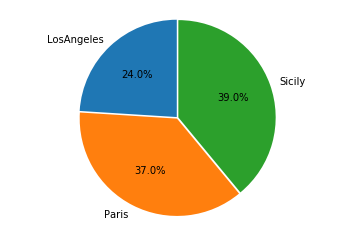

In [6]:
# The Genderize API allows categorize freely only 1000 names per day, so I create a random subset of our data with 100 rows
listings_data_random_subset = listings_data.sample(n=100)
utils.my_plot_pie(listings_data_random_subset.groupby('location').apply(lambda x: len(x)))

In [7]:
gend_res = Genderize().get(list(listings_data_random_subset.host_name.values))
gen_res_list = [x['gender'].encode("ascii") if (x['gender'] is not None) and 
                (x['probability']>0.5) else 'unknown' for x in gend_res]
gen_prob_list = [x['probability'] for x in gend_res]

In [8]:
listings_data_random_subset['gender']=gen_res_list
listings_data_random_subset['gender_probability']=gen_prob_list

/usr/local/lib/python2.7/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


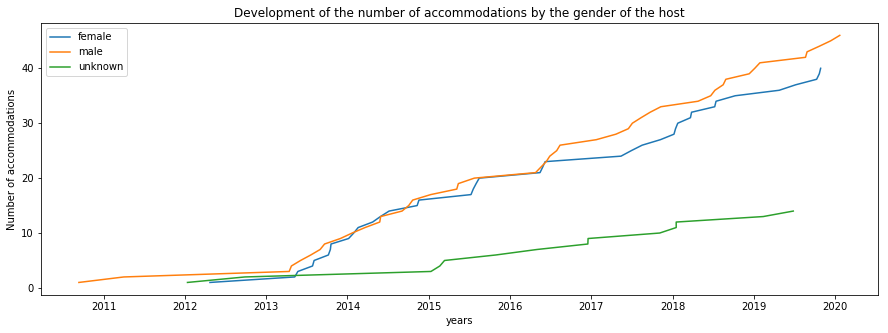

In [9]:
listings_data_random_subset = listings_data_random_subset.sort_values('host_since')
listings_data_random_subset['temp']=1
plt.figure(figsize=(15,5))
listings_data_random_subset.groupby('gender').apply(lambda x:
                                                    plt.plot(x['host_since'],np.cumsum(x['temp']),'-',label=x.name))
plt.legend()
plt.title('Development of the number of accommodations by the gender of the host')
plt.xlabel('years')
plt.ylabel('Number of accommodations')
plt.show()
del listings_data_random_subset['temp']

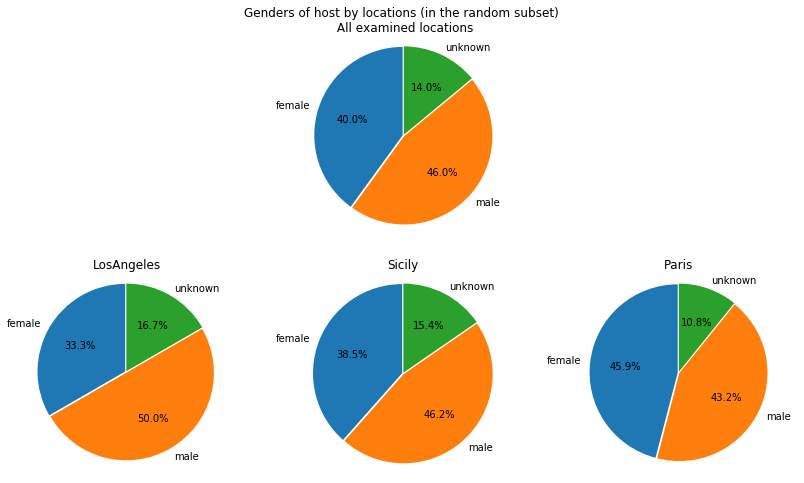

In [10]:
plt.figure(figsize=(14,8))
plt.subplot(232)
utils.my_plot_pie(listings_data_random_subset.groupby('gender').apply(lambda x: len(x)))
plt.title('Genders of host by locations (in the random subset) \n All examined locations')

for location, fig_loc in zip(list(listings_data_random_subset.index.get_level_values(0).unique()),[234,235,236]):
    plt.subplot(fig_loc)
    utils.my_plot_pie(listings_data_random_subset.loc[location].groupby('gender').apply(lambda x: len(x)),title=location)

# 2. Numeric features correltaions

In [11]:
numeric_features = pd.DataFrame()
print('not numeric:'),
for column in listings_data.columns:
    if listings_data[column].dtypes == 'int64' or listings_data[column].dtypes == 'float64':
        numeric_features[column] = listings_data[column]
    else: 
        print(column + ','),
numeric_features.index = listings_data.index
print('\n\nnumber of columns: ' + str(listings_data.shape[1]) + " --> " + str(numeric_features.shape[1]))


#plt.figure()
#col_data = listings_data[column].values
#plt.hist(col_data[~np.isnan(col_data)])
#plt.title(column)
#plt.show()
#else:
#print(column + ": " + str(listings_data[column].dtypes))

not numeric: listing_url, last_scraped, name, summary, space, description, experiences_offered, neighborhood_overview, notes, transit, access, interaction, house_rules, picture_url, host_url, host_name, host_since, host_location, host_about, host_response_time, host_response_rate, host_acceptance_rate, host_is_superhost, host_thumbnail_url, host_picture_url, host_neighbourhood, host_verifications, host_has_profile_pic, host_identity_verified, street, neighbourhood, neighbourhood_cleansed, neighbourhood_group_cleansed, city, state, zipcode, market, smart_location, country_code, country, is_location_exact, property_type, room_type, bed_type, amenities, security_deposit, cleaning_fee, extra_people, calendar_updated, has_availability, calendar_last_scraped, first_review, last_review, requires_license, license, jurisdiction_names, instant_bookable, is_business_travel_ready, cancellation_policy, require_guest_profile_picture, require_guest_phone_verification, 

number of columns: 106 --> 45


In [12]:
url_columns = [x for x in numeric_features.columns if 'url' in x]
id_columns = [x for x in numeric_features.columns if 'id' in x]
gps_columns = [x for x in numeric_features.columns if 'tude' in x]
nigths_columns = [x for x in numeric_features.columns if 'm_m' in x]
calculated_columns = [x for x in numeric_features.columns if 'calculated' in x]

numeric_features.drop(url_columns+
                      id_columns+
                      gps_columns+
                      nigths_columns+
                      calculated_columns, axis=1, inplace=True)
numeric_features.shape[1]

30

In [13]:
list(numeric_features.columns)

['host_listings_count',
 'host_total_listings_count',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'square_feet',
 'price',
 'weekly_price',
 'monthly_price',
 'guests_included',
 'minimum_nights',
 'maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month',
 'host_for_days']

In [14]:
review_features = [col for col in numeric_features.columns if 'review' in col]
review_features.remove('number_of_reviews_ltm')
review_features.remove('reviews_per_month')
display(review_features)

['number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value']

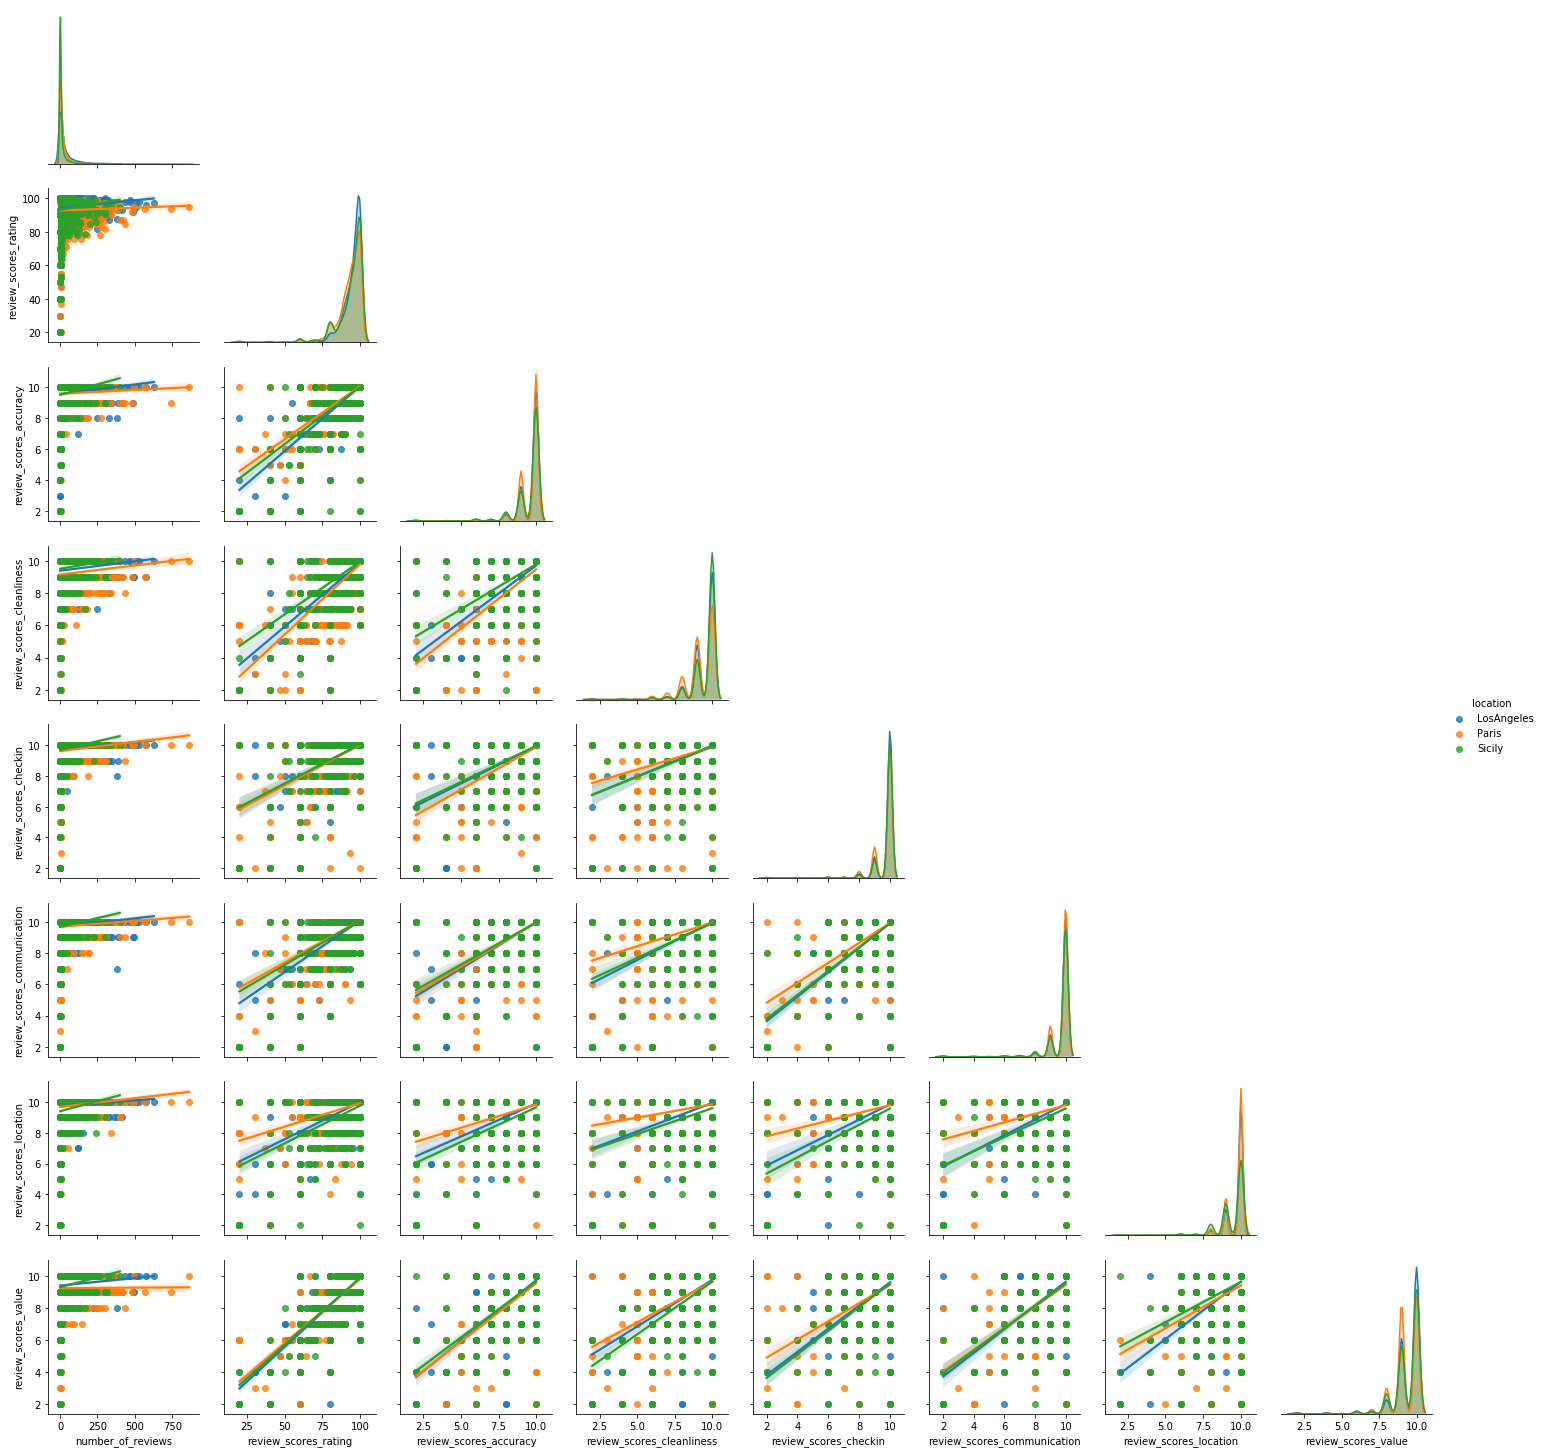

In [15]:
import seaborn as sns
sns.pairplot(listings_data.reset_index()[review_features+['location']].iloc[::10],corner=True,kind="reg",hue="location")
plt.show()

In [16]:
def calculate_corr(group):
    df = np.round(group[review_features].corr(),2)
    display(utils.format_vertical_headers(df))
calculate_corr(listings_data)
listings_data.groupby('location').apply(calculate_corr)

,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
number_of_reviews,1,0.06,0.08,0.07,0.08,0.07,0.1,0.06
review_scores_rating,0.06,1,0.74,0.7,0.6,0.65,0.49,0.77
review_scores_accuracy,0.08,0.74,1,0.59,0.59,0.63,0.46,0.68
review_scores_cleanliness,0.07,0.7,0.59,1,0.47,0.48,0.34,0.61
review_scores_checkin,0.08,0.6,0.59,0.47,1,0.69,0.4,0.54
review_scores_communication,0.07,0.65,0.63,0.48,0.69,1,0.43,0.59
review_scores_location,0.1,0.49,0.46,0.34,0.4,0.43,1,0.48
review_scores_value,0.06,0.77,0.68,0.61,0.54,0.59,0.48,1


,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
number_of_reviews,1,0.09,0.1,0.1,0.1,0.1,0.08,0.08
review_scores_rating,0.09,1,0.81,0.75,0.68,0.74,0.6,0.81
review_scores_accuracy,0.1,0.81,1,0.67,0.66,0.7,0.57,0.74
review_scores_cleanliness,0.1,0.75,0.67,1,0.53,0.57,0.49,0.67
review_scores_checkin,0.1,0.68,0.66,0.53,1,0.74,0.53,0.61
review_scores_communication,0.1,0.74,0.7,0.57,0.74,1,0.55,0.66
review_scores_location,0.08,0.6,0.57,0.49,0.53,0.55,1,0.59
review_scores_value,0.08,0.81,0.74,0.67,0.61,0.66,0.59,1


,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
number_of_reviews,1,0.03,0.05,0.06,0.07,0.04,0.09,0.02
review_scores_rating,0.03,1,0.73,0.71,0.58,0.63,0.42,0.75
review_scores_accuracy,0.05,0.73,1,0.58,0.57,0.6,0.4,0.66
review_scores_cleanliness,0.06,0.71,0.58,1,0.42,0.44,0.31,0.6
review_scores_checkin,0.07,0.58,0.57,0.42,1,0.66,0.34,0.51
review_scores_communication,0.04,0.63,0.6,0.44,0.66,1,0.36,0.56
review_scores_location,0.09,0.42,0.4,0.31,0.34,0.36,1,0.4
review_scores_value,0.02,0.75,0.66,0.6,0.51,0.56,0.4,1


,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
number_of_reviews,1,0.05,0.1,0.06,0.08,0.09,0.09,0.09
review_scores_rating,0.05,1,0.71,0.65,0.57,0.61,0.51,0.77
review_scores_accuracy,0.1,0.71,1,0.57,0.58,0.62,0.46,0.68
review_scores_cleanliness,0.06,0.65,0.57,1,0.47,0.48,0.35,0.59
review_scores_checkin,0.08,0.57,0.58,0.47,1,0.7,0.41,0.53
review_scores_communication,0.09,0.61,0.62,0.48,0.7,1,0.42,0.57
review_scores_location,0.09,0.51,0.46,0.35,0.41,0.42,1,0.52
review_scores_value,0.09,0.77,0.68,0.59,0.53,0.57,0.52,1


""


In [17]:
df_review_means = listings_data.groupby('location').apply(utils.calc_review_means, review_features)
df_review_means = df_review_means.append(pd.DataFrame(utils.calc_review_means(listings_data,review_features),columns=['AllTogether']).transpose())
df_review_means

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews
LosAngeles,95.493742,9.724052,9.539021,9.837609,9.813881,9.766589,9.517030,1.0
Paris,93.028543,9.634593,9.281183,9.731263,9.742467,9.761290,9.253852,1.0
Sicily,94.255179,9.709175,9.616145,9.844864,9.832836,9.569377,9.492065,1.0
AllTogether,94.263659,9.684820,9.447523,9.795455,9.788106,9.728965,9.404995,1.0


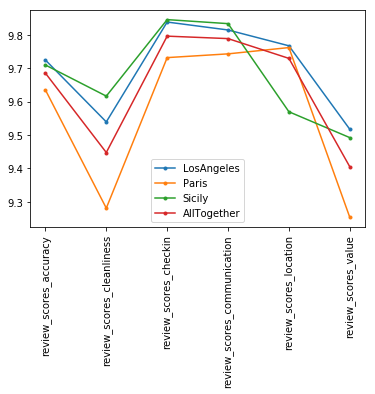

In [18]:
review_to_plot = df_review_means.drop(['review_scores_rating','number_of_reviews'],axis=1)
plt.figure()
for index, row in review_to_plot.iterrows():
    plt.plot(row,'.-',label=index)
plt.xticks(rotation=90)
plt.legend()
plt.show()

# 3. Amenities vs. price

In [19]:
amenities = list(listings_data['amenities'].replace('[\{}"]','',regex=True))
amenities_list = [x.split(',') for x in amenities]
flat_amenities = [item for sublist in amenities_list for item in sublist]

In [20]:
print('number of uniqe amenities: ' + str(len(np.unique(flat_amenities))))
amenities_freq = pd.DataFrame(flat_amenities, columns=['amenities']).groupby('amenities').apply(lambda x: len(x))
amenities_freq = amenities_freq.sort_values(ascending=False)[:30]

number of uniqe amenities: 360


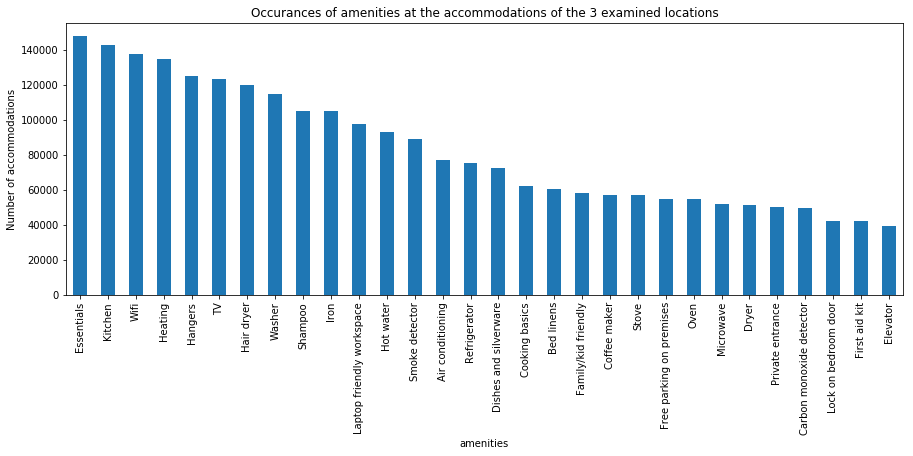

In [21]:
plt.figure(figsize=(15,5))
amenities_freq.plot.bar()
plt.title('Occurances of amenities at the accommodations of the 3 examined locations')
plt.ylabel('Number of accommodations')
plt.show()

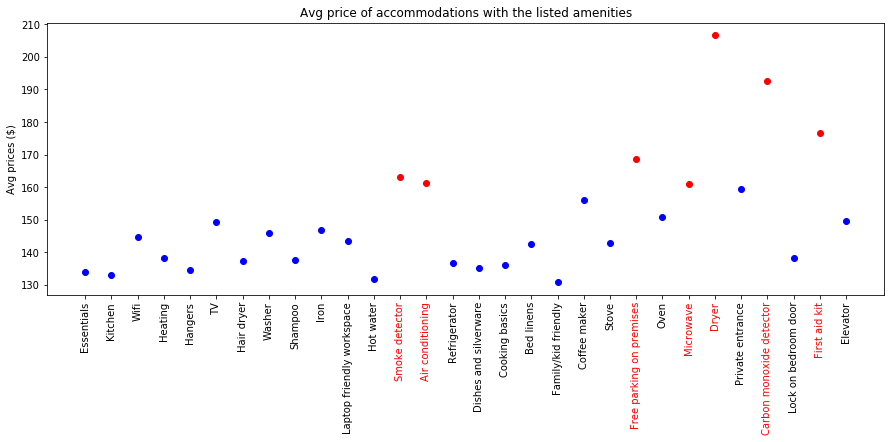

In [22]:
fig, ax = plt.subplots(figsize=(15,5))
ticks_to_red=[]
i=0
for amen in amenities_freq.index.values:
    mask = listings_data['amenities'].str.contains(amen)
    avg_price = (listings_data[mask]['price']).mean() # /listings_data[mask]['accommodates']
    if avg_price>160:
        ax.plot(amen,avg_price,'ro')
        ticks_to_red = ticks_to_red + [i]
    else:
        ax.plot(amen,avg_price,'bo')
    i=i+1
plt.xticks(rotation=90)
for tick in ticks_to_red:
    ax.get_xticklabels()[tick].set_color("red")
plt.ylabel('Avg prices ($)')
plt.title('Avg price of accommodations with the listed amenities')
plt.show()

# 4. Prices and review scores by location in Paris

In [23]:
N = 48.8848
W = 2.2937
E = 2.3623
S = 48.8463

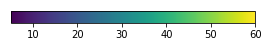

Accommodation prices ($) in Paris


In [24]:
listings_data_Paris = listings_data.loc['Paris']
lats = listings_data_Paris.latitude[::30]
lons = listings_data_Paris.longitude[::30]
color= np.clip(listings_data_Paris.price[::30]/listings_data_Paris.accommodates[::30],0,60)

plt.figure(figsize=(9, 1.5))
asd = plt.scatter(lons, lats, c = color)
plt.gca().set_visible(False)
plt.colorbar(orientation='horizontal')
plt.show()

print("Accommodation prices ($) in Paris")

fig,ax=plt.subplots(figsize=(8,8))
ax.scatter(lons, lats, c = color)

rect = patches.Rectangle((W,S),E-W,N-S,linewidth=1,edgecolor='r', facecolor=None)
ax.add_patch(rect)
plt.axis('equal')
mplleaflet.display(fig=fig)

In [26]:
listings_data_Paris.loc[:,'inner_city'] = ((listings_data_Paris.longitude > W) &
                                           (listings_data_Paris.longitude < E) &
                                           (listings_data_Paris.latitude < N) &
                                           (listings_data_Paris.latitude > S))

listings_data_Paris_inner = listings_data_Paris[listings_data_Paris['inner_city']==True]
listings_data_Paris_suburb = listings_data_Paris[listings_data_Paris['inner_city']==False]

print('Number of accommodations in the inner city and suburb: ' 
      + str(listings_data_Paris_inner.shape[0]) + ", "
      + str(listings_data_Paris_suburb.shape[0]))
listings_data_Paris_suburb = listings_data_Paris_suburb.iloc[:listings_data_Paris_inner.shape[0],:]
print('Number of accommodations in the inner city and suburb (balanced classes): '
      + str(listings_data_Paris_inner.shape[0]) + ", "
      + str(listings_data_Paris_suburb.shape[0]))

Number of accommodations in the inner city and suburb: 22317, 44097
Number of accommodations in the inner city and suburb (balanced classes): 22317, 22317


In [27]:
Paris_innercity_suburb_comparison = pd.DataFrame(utils.calc_review_means(listings_data_Paris_inner, review_features)[:-1],columns=['inner'])
Paris_innercity_suburb_comparison.loc[:,'suburb'] = utils.calc_review_means(listings_data_Paris_suburb,review_features)[:-1]
Paris_innercity_suburb_comparison = np.round(Paris_innercity_suburb_comparison.append(pd.DataFrame([listings_data_Paris_inner[price_columns].mean(), 
                                                       listings_data_Paris_suburb[price_columns].mean()], 
                                                      index=['inner', 'suburb']).transpose()),2)

In [28]:
Paris_innercity_suburb_comparison.style.apply(utils.highlight_max,axis=1)

,inner,suburb
review_scores_rating,92.95,93.37
review_scores_accuracy,9.61,9.67
review_scores_cleanliness,9.31,9.29
review_scores_checkin,9.73,9.78
review_scores_communication,9.73,9.78
review_scores_location,9.89,9.68
review_scores_value,9.23,9.31
price,167.97,94
weekly_price,769.61,565.54
monthly_price,2454.51,1839.41


# 5. Predict price class with xgboost decision tree

In [29]:
listings_data = listings_data.sort_values('price')

In [30]:
label_encoder = LabelEncoder()
listings_data['location_cat'] = label_encoder.fit_transform(listings_data.reset_index()[['location']])

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [31]:
input_columns = list(numeric_features.columns) + ['location_cat']
input_columns.remove('price')
input_columns.remove('weekly_price')
input_columns.remove('monthly_price')

dataset_input = listings_data.reset_index()[input_columns + ['location','id']].set_index(['location','id'])
dataset_target = pd.cut(listings_data['price'],bins=[-np.inf,50,100,200,np.inf],labels=[0,1,2,3])
trainset_input, testset_input, trainset_target, testset_target = train_test_split(dataset_input, 
                                                                                  dataset_target, 
                                                                                  test_size=0.2)

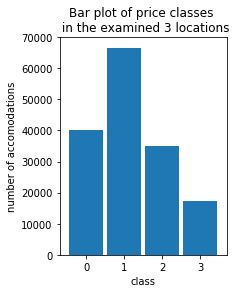

In [32]:
plt.figure(figsize=(3,4))
dataset_target.value_counts().loc[dataset_target.values.unique()].plot.bar(x='index',y='price', width=0.9)
plt.title('Bar plot of price classes \n in the examined 3 locations')
plt.ylabel('number of accomodations')
plt.xlabel('class')
plt.xticks(rotation=0)
plt.show()

In [33]:
clf = xgb.XGBClassifier()
clf.fit(trainset_input, trainset_target)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [34]:
pred = clf.predict(testset_input)

In [35]:
pd.DataFrame(confusion_matrix(pred,list(testset_target.values)))

,0,1,2,3
0,4193,2445,395,97
1,3722,9900,3720,562
2,113,899,2258,752
3,34,86,693,1987


In [36]:
print('F1-score: ' + str(f1_score(pred,list(testset_target.values),average='weighted')))

F1-score: 0.5876114624822613


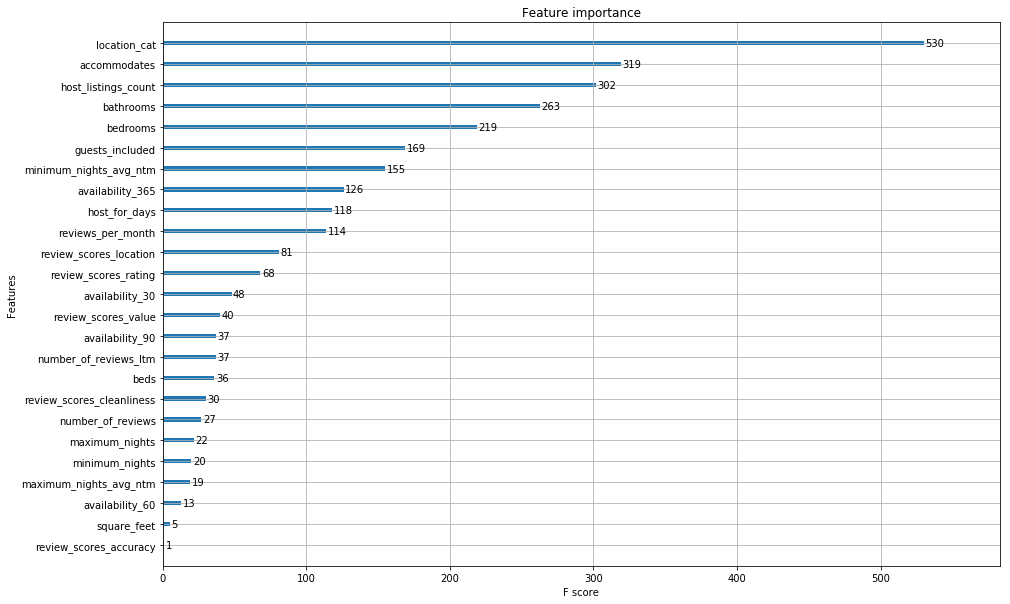

In [37]:
fig,ax = plt.subplots(figsize=(15,10))
plot_importance(clf, ax=ax)
plt.show()